In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
'./drive/My Drive/Colab Notebooks/MHK US Equity.xlxs'

'./drive/My Drive/Colab Notebooks/MHK US Equity.xlxs'

In [5]:
df = pd.read_excel(r'./drive/My Drive/Colab Notebooks/MHK US Equity.xlsx')
df_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,DATA,PX_LAST,PX_ASK,PX_BID,NET_INCOME_MARGIN_ADJUSTED,WACC_COST_DEBT,BS_ST_BORROW,BS_LT_BORROW,IS_RD_EXPEND,PX_TO_BOOK_RATIO,IS_INT_EXPENSE,CF_FREE_CASH_FLOW,QUICK_RATIO,CUR_RATIO,WACC,WACC_COST_DEBT.1,WACC_COST_EQUITY,ROC_WACC_RATIO,BEST_NET_DEBT,NET_DEBT_TO_SHRHLDR_EQTY,NET_DEBT_%_CAPITAL,EBITDA,EBIT,BEST_NET_INCOME,EBITDA_TO_REVENUE,EBIT_TO_NET_SALES,BS_TOT_ASSET,SALES_REV_TURN,BEST_EST_PE_CUR_YR,BEST_PE_RATIO,CURR_ENTP_VAL,REVENUE_GROWTH_ADJUSTED_5Y_CAGR,SALES_GROWTH,EBITDA_GROWTH,GEO_GROW_EBITDA,NET_INC_GROWTH,GEO_GROW_NET_INC,BEST_EPS_NXT_YR,MOV_AVG_50D,MOV_AVG_200D,RSI_14D,RSI_30D,RSI_9D,PX_VOLUME
0,2013-12-31,148.90,148.91,148.90,7.0948,3.3894,127.218,2132.79,0,2.4261,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13029.0296,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,138.8840,123.2779,65.1380,65.1935,67.9928,533632
1,2014-01-01,148.90,148.91,148.90,7.0948,3.3894,127.218,2132.79,0,2.4261,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13029.0296,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,138.8840,123.2779,65.1380,65.1935,67.9928,533632
2,2014-01-02,149.11,149.10,149.07,7.0948,3.3894,127.218,2132.79,0,2.4295,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13044.2809,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,139.3660,123.4603,65.4500,65.3393,68.4927,676997
3,2014-01-03,149.45,149.48,149.47,7.0948,3.3894,127.218,2132.79,0,2.4351,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13068.9733,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,139.8022,123.6346,65.9809,65.5808,69.3643,521291
4,2014-01-06,147.34,147.40,147.36,7.0948,3.3894,127.218,2132.79,0,2.4007,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,12915.7349,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,140.1838,123.8148,59.8358,62.7730,58.1367,470527


In [4]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

from __future__ import print_function, division
from tensorflow.contrib import rnn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [6]:
minmax = MinMaxScaler().fit(df.iloc[:, 3:4].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 3:4].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.216807
1,0.216807
2,0.217788
3,0.220095
4,0.207925


In [7]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1434, 44), (1404, 1), (30, 1))

In [0]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.contrib.rnn.GRUCell(size_layer)

        rnn_cells = tf.contrib.rnn.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [0]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [0]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [11]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.


train loop: 100%|██████████| 300/300 [03:58<00:00,  1.26it/s, acc=97.4, cost=0.00179]


simulation 2


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [04:02<00:00,  1.24it/s, acc=90.4, cost=0.0229]


simulation 3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [04:04<00:00,  1.23it/s, acc=97.6, cost=0.00157]


simulation 4


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [04:02<00:00,  1.24it/s, acc=97.4, cost=0.00177]


simulation 5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s, acc=93.9, cost=0.00866]


simulation 6


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [04:02<00:00,  1.24it/s, acc=97, cost=0.0024]


simulation 7


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s, acc=95, cost=0.00656]


simulation 8


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [04:09<00:00,  1.20it/s, acc=97.1, cost=0.00231]


simulation 9


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [04:07<00:00,  1.21it/s, acc=96.8, cost=0.00248]


simulation 10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s, acc=97.4, cost=0.00187]


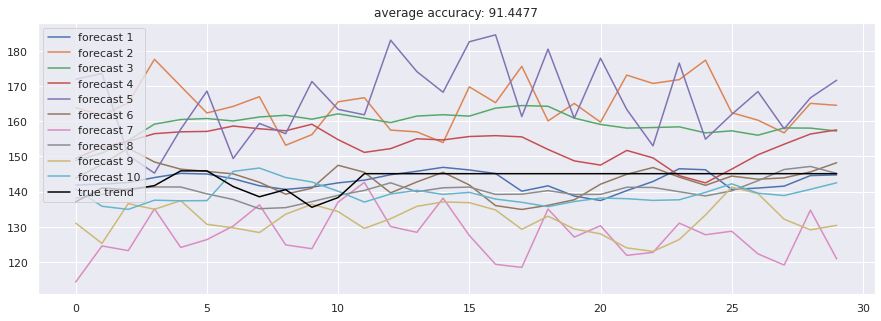

In [12]:
accuracies = [calculate_accuracy(df['PX_LAST'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['PX_LAST'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()